In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
os.environ['MKL_NUM_THREADS'] = "1"
os.environ['NUMEXPR_NUM_THREADS'] = "1"
os.environ['OMP_NUM_THREADS'] = "1"
os.environ['OPENBLAS_NUM_THREADS'] = "1"
os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
from matplotlib import pyplot as plt
%matplotlib inline

import glob

# suppress natural naming warnings
import warnings
from tables import NaturalNameWarning
warnings.filterwarnings('ignore', category=NaturalNameWarning)

## Defines Settings

In [2]:
selection_version = 'version-001-p00'

plot_dir = '/home/mhuennefeld/public_html/analyses/DNNCascade/plots/data_mc/selection_{}'.format(selection_version)
df_dir = '/data/ana/PointSource/DNNCascade/analysis/{}/'.format(selection_version)


In [3]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Load Data

In [4]:
dfs = {}

print('Loading BFRv1 ...')
dfs['BFRv1'] = pd.read_hdf(
    df_dir + '/MC_NuGen_bfrv1_2153x.hdf', key='df',
)

print('Loading SnowStorm ...')
dfs['SnowStorm']  = pd.read_hdf(
    df_dir + '/systematics/SnowStorm_Spice321/MC_NuGen_snowstorm_214xx.hdf', key='df',
)

print('Loading exp ...')
df_exp_list = []
for y in range(2011, 2021):
     df_exp_list.append(pd.read_hdf(
        '{}/IC86_{}_exp.hdf'.format(df_dir, y), key='df',
    ))
dfs['_exp']  = pd.concat(df_exp_list, ignore_index=True)

print('Loading MuonGun ...')
dfs['MuonGun']  = pd.read_hdf(
    df_dir + '/MC_MuonGun_2131x.hdf', key='df',
)

print('Loading CORSIKA ...')
dfs['CORSIKA']  = pd.read_hdf(
    df_dir + '/MC_CORSIKA_20904.hdf', key='df',
) 


Loading BFRv1 ...
Loading SnowStorm ...
Loading exp ...
Loading MuonGun ...
Loading CORSIKA ...


## Livetime and Burnsample

In [5]:
mask_burn = dfs['_exp']['I3EventHeader_Run'] % 10 == 0
dfs['exp'] = dfs['_exp'][mask_burn]

burnsample_fraction = np.sum(mask_burn) / len(dfs['_exp'])
print('Burn sample fraction: {:3.3f}%'.format(burnsample_fraction * 100))

for name, df in dfs.items():
    if 'exp' not in name:
        print('Adjusting weights for: {}'.format(name))
        df['weights_new'] = df['weights'] * burnsample_fraction

Burn sample fraction: 9.903%
Adjusting weights for: BFRv1
Adjusting weights for: SnowStorm
Adjusting weights for: MuonGun
Adjusting weights for: CORSIKA


In [6]:
_livetime = dfs['BFRv1']['weights_livetime'].iloc[0]
livetime = _livetime * burnsample_fraction
print('Livetime: {} days'.format(_livetime / 60 / 60 / 24))
print('Livetime [Burnsample]: {} days'.format(livetime / 60 / 60 / 24))


Livetime: 3519.6846812828426 days
Livetime [Burnsample]: 348.5438462273548 days


In [7]:
dfs.keys()

dict_keys(['BFRv1', 'SnowStorm', '_exp', 'MuonGun', 'CORSIKA', 'exp'])

## Snowstorm Systematics

In [8]:
priors_dict = {
    #'Absorption': [0.930, 1.070], #[0.9, 1.0],
    #'Scattering': [0.953, 1.012], #[0.9, 1.1],
    #'AnisotropyScale': [0, 2], #[0., 2.],
    #'DOMEfficiency': [0.9, 1.1],
    #'HoleIceForward_Unified_00': [-0.800, 0.800], #[-0.65, 0.65],
    #'HoleIceForward_Unified_01': [-0.120, -0.040], #[-0.2, 0.2],
}
snowstorm_simulation_range = {
    'Scattering': [0.9, 1.1],
    'Absorption': [0.9, 1.1],
    'AnisotropyScale': [0., 2.],
    'DOMEfficiency': [0.9, 1.1],
    'HoleIceForward_Unified_00': [-1.0, 1.0],
    'HoleIceForward_Unified_01': [-0.2, 0.2],
}

def rename_snowstorm_params(df):
    parameter_names=[
        'Scattering', 'Absorption', 'AnisotropyScale', 
        'DOMEfficiency', 'HoleIceForward_Unified_00', 
        'HoleIceForward_Unified_01',
    ]
    for i, param in enumerate(parameter_names):
        df[param] = df['SnowstormParameters_{:05d}'.format(i)]

def get_snowstorm_multiplier(
        df,
        priors_dict,
        simulation_range=snowstorm_simulation_range,
        verbose=False,
    ):
    """Reweight snowstorm
    
    Parameters
    ----------
    df: DataFrame or dict
        The dataframe or dictionary containing the SnowStorm
        parameters. 
    priors_dict : dict
        A dictionary with uniform Snowstorm priors defined
        as a tuple of (min, max).
    """
    w_multiplier = 1.0
    mask = np.ones_like(df[list(simulation_range.keys())[0]], dtype=bool)
    for name, prior in priors_dict.items():
        
        prior_orig = simulation_range[name]
        assert prior[1] >= prior[0] and prior_orig[1] >= prior_orig[0]
        assert prior[0] >= prior_orig[0] and prior[0] <= prior_orig[1]
        assert prior[1] >= prior_orig[0] and prior[1] <= prior_orig[1]
        
        range_sim = prior_orig[1] - prior_orig[0]
        range_new = prior[1] - prior[0]
        w_multiplier *= range_sim / range_new
        mask = np.logical_and(mask, df[name] >= prior[0])
        mask = np.logical_and(mask, df[name] <= prior[1])
    
    
    snowstorm_multiplier = np.ones_like(mask) * mask.astype(float) * w_multiplier
    if verbose:
        print(np.sum(mask) / float(len(mask)), 1./w_multiplier, w_multiplier)
        print(np.sum(mask), len(mask), np.sum(snowstorm_multiplier))
    return snowstorm_multiplier
        
if 'SnowStorm' in dfs:
    print('Reweighting Snowstorm set')
    rename_snowstorm_params(dfs['SnowStorm'])
    dfs['SnowStorm']['snowstorm_multiplier'] = get_snowstorm_multiplier(
        df=dfs['SnowStorm'],
        priors_dict=priors_dict,
        verbose=True,
    )



Reweighting Snowstorm set
1.0 1.0 1.0
2217128 2217128 2217128.0


## Add Cos(Zenith)

In [30]:
for df in dfs.values():
    for key in df.keys():
        if key[-17:] == 'I3Particle_zenith':
            df[key[:-6] + 'cos_zen'] = np.cos(df[key])

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Create Combined MC DataFrame

In [31]:
nugen_keys = ['BFRv1']
muon_keys = ['MuonGun', 'CORSIKA']

shared_keys = None
for name, df in dfs.items():
    if 'exp' not in name:
        if shared_keys is None:
            shared_keys = set(df.columns.values)
        else:
            shared_keys = shared_keys.intersection(
                set(df.columns.values))

df_list = []
for name in nugen_keys:
    print('NuGen:', name)
    df_red = dfs[name][list(shared_keys)]
    df_red['mc_origin'] = 'NuGen_' + name
    df_list.append(df_red)
for name in muon_keys:
    print('Muon:', name)
    df_red = dfs[name][list(shared_keys)]
    df_red['mc_origin'] = 'Muon_' + name
    df_list.append(df_red)
    
df_mc = pd.concat(df_list, ignore_index=True)
del df_list
print(len(df_mc))

NuGen: BFRv1


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Muon: MuonGun
Muon: CORSIKA
399400


## Data/MC Plots

In [32]:
from disteval.visualization.comparison_plotter import ComparisonPlotter

def get_binning_dict():
    n_bins = 25
    binning_dict = {}
    for key in dfs['exp'].keys():
        if 'energy' in key.lower():
            binning_dict[key] = np.logspace(2, 8, n_bins)
        elif key[:4] == 'BDT_' and 'astroness' in key:
            binning_dict[key] = np.linspace(0, 1, 20)
        elif 'azimuth' in key.lower():
            binning_dict[key] = np.linspace(0, 2*np.pi, n_bins)
        elif 'zenith' in key.lower():
            binning_dict[key] = np.linspace(0, np.pi, n_bins)
        elif 'cos_zen' in key.lower():
            binning_dict[key] = np.linspace(-1, 1., 20)
        elif '_q_' in key.lower():
            binning_dict[key] = np.logspace(0, 5, n_bins)
        elif '_p_is_veto_event' == key.lower()[-16:]:
            binning_dict[key] = np.linspace(0, 1, 30)
    return binning_dict
        

def data_mc_plot(key, df_mc, df_exp,
                 weight_key='weights_new',
                 mask_func=None, add_parts=True, 
                 bins=20, binning_dict=None, 
                 snowstorm_priors=None):
    """Draw Data/MC plot
    """
    if binning_dict is None:
        binning_dict = get_binning_dict()
        
    if 'energy' in key.lower() or '_q_' in key.lower():
        xscale = 'log'
    else:
        xscale = 'linear'
    
    mc_origin = df_mc.mc_origin
    values_sim = df_mc[key]
    weight_sim = df_mc[weight_key]
    values_exp = df_exp[key]
    
    if mask_func is not None:
        mask_sim = mask_func(df_mc)
        values_sim = values_sim[mask_sim]
        weight_sim = weight_sim[mask_sim]
        mc_origin = mc_origin[mask_sim]
        mask = mask_func(df_exp)
        values_exp = values_exp[mask]
    
    
    if key not in binning_dict:
        if isinstance(bins, int):
            binning_dict[key] = np.linspace(
                np.nanmin(values_exp), np.nanmax(values_exp), 
                bins)
        else:
            binning_dict[key] = bins
    
    plotter = ComparisonPlotter()
    plotter.add_element('LimitedMCHisto',
                        log_y=True,
                        alpha=[0.68, 0.9, 0.99],
                        y_label='Events in {:3.3f} days'.format(
                                            livetime / (3600*24)),
                        binning_dict=binning_dict)
    plotter.add_element('LimitedMCRatio', zoomed=False,
                        y_label='p-value',
                        y_min_log_prob=-2.8,
                        )

    plotter.add_element('Normalization', normalize='test_livetime')
    plotter.add_ref('MC simulation',
                    values_sim,
                    livetime=livetime,
                    color='#1f77b4',
                    weights=weight_sim,
                    cmap='PuBu')
    if add_parts:
        for part_name in df_mc.mc_origin.unique():
            mask_part = mc_origin == part_name
            if np.sum(weight_sim[mask_part]) > 0.:
                plotter.add_ref_part(part_name,
                                     values_sim[mask_part],
                                     livetime=livetime,
                                     weights=weight_sim[mask_part])
    
    if snowstorm_priors is not None:
        df_ss = df_nugen['SnowStorm']
        values_ss = df_ss[key].values
        weight_ss_orig = df_ss.weight_ss_orig.values
        if mask_func is not None:
            mask_ss = mask_func(df_ss)
            values_ss = values_ss[mask_ss]
            weight_ss_orig = weight_ss_orig[mask_ss]

        for prior_name, prior_dict in snowstorm_priors.items():
            w_multipler = get_snowstorm_multiplier(
                df=df_ss,
                priors_dict=prior_dict,
            )
            if mask_func is not None:
                w_multipler = w_multipler[mask_ss]
            if np.sum(mask_ss) > 0:
                plotter.add_ref_part(prior_name,
                                     values_ss,
                                     livetime=livetime,
                                     weights=weight_ss_orig*w_multipler)
            
    plotter.add_test('Data',
                     values_exp,
                     livetime=livetime,
                     color='w')
    fig, ax_dict, result_tray = plotter.draw(
        x_label=key,
        #max_ticks_per_side=2,
    )
    ax_dict['PlotHistAggerwal'].set_xscale(xscale)
    ax_dict['PlotRatioAggerwal'].set_xscale(xscale)
    #ax_dict['PlotHistAggerwal'].set_ylim(
    #    max(1e-0, np.min(
    #        result_tray.sum_w[result_tray.sum_w > 0])))

    #mpl.rcParams.update(mpl.rcParamsDefault)
    return fig, ax_dict, result_tray


  0%|          | 0/369 [00:00<?, ?it/s]

BDT_astroness_bdt_mu0100_cscd0000_01_pred_000



0it [00:00, ?it/s]
21it [00:00, 137.01it/s]A
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)


BDT_astroness_bdt_mu0100_cscd0000_wo_zenith_01_pred_000



0it [00:00, ?it/s]
21it [00:00, 143.43it/s]A
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)

0it [00:00, ?it/s]

BDT_bdt_max_depth_4_n_est_1000lr_0.01_seed_3_train_size_50_pred_000



21it [00:00, 106.78it/s]A
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)

0it [00:00, ?it/s]

BDT_bdt_max_depth_4_n_est_1000lr_0.01_seed_3_train_size_50_pred_001



21it [00:00, 110.80it/s]
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)

0it [00:00, ?it/s]

BDT_bdt_max_depth_4_n_est_2000lr_0_02_seed_3_train_size_50_pred_000



10it [00:00, 97.60it/s]
21it [00:00, 85.92it/s]
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)

0it [00:00, ?it/s]

BDT_bdt_max_depth_4_n_est_2000lr_0_02_seed_3_train_size_50_pred_001



7it [00:00, 64.85it/s]
21it [00:00, 82.92it/s]
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)


EventGeneratorSelectedRecoNNCircularUncertainty



0it [00:00, ?it/s]
9it [00:00, 81.79it/s]
21it [00:00, 77.37it/s]
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)

0it [00:00, ?it/s]

EventGeneratorSelectedRecoNNKeyNumber


21it [00:00, 235.97it/s]
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)


EventGeneratorSelectedRecoNN_I3Particle_azimuth



0it [00:00, ?it/s]
10it [00:00, 90.20it/s]
26it [00:00, 82.96it/s]
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)


EventGeneratorSelectedRecoNN_I3Particle_cos_zen



0it [00:00, ?it/s]
9it [00:00, 79.94it/s]
21it [00:00, 76.03it/s]
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)


EventGeneratorSelectedRecoNN_I3Particle_energy



0it [00:00, ?it/s]
26it [00:00, 157.31it/s]A
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)

0it [00:00, ?it/s]

EventGeneratorSelectedRecoNN_I3Particle_time


21it [00:00, 338.73it/s]
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)


EventGeneratorSelectedRecoNN_I3Particle_x



0it [00:00, ?it/s]
9it [00:00, 88.69it/s]
21it [00:00, 77.69it/s]
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)


EventGeneratorSelectedRecoNN_I3Particle_y



0it [00:00, ?it/s]
9it [00:00, 89.29it/s]
21it [00:00, 82.47it/s]
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)


EventGeneratorSelectedRecoNN_I3Particle_z



0it [00:00, ?it/s]
8it [00:00, 73.97it/s]
21it [00:00, 84.58it/s]
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)


EventGeneratorSelectedRecoNN_I3Particle_zenith



0it [00:00, ?it/s]
11it [00:00, 108.64it/s]
26it [00:00, 89.56it/s] 
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)

0it [00:00, ?it/s]

EventGeneratorSelectedRecoNN_cov_matrix_cov_sand_circular_unc


21it [00:00, 263.53it/s]
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)

0it [00:00, ?it/s]

NN_sigma_nn_1cascade_mu0100_cscd0000_01_pred_000



21it [00:00, 142.32it/s]A
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)

0it [00:00, ?it/s]

NN_sigma_nn_2cascade_mu0100_cscd0000_01_pred_000



21it [00:00, 132.89it/s]A
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)


NN_sigma_nn_ind2cascade_mu0100_cscd0000_01_pred_000



0it [00:00, ?it/s]
21it [00:00, 114.82it/s]A
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:582: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  self.ax.set_yscale('log', nonposy='clip')
/mnt/lfs7/user/mhuennefeld/software/repositories/pydisteval/disteval/visualization/comparison_plotter/parts.py:901: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(M_t)


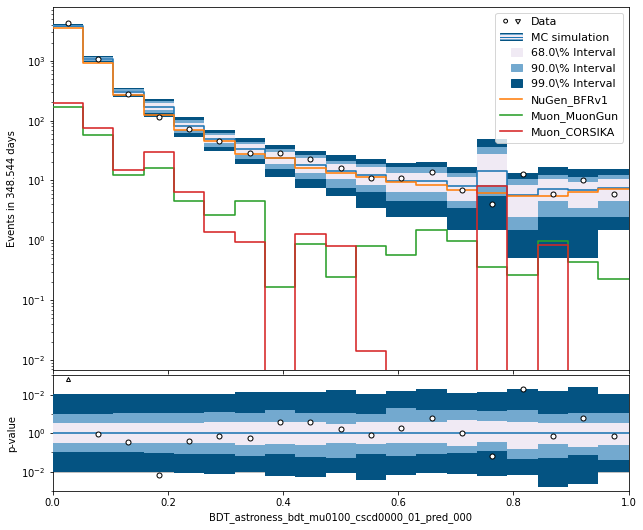

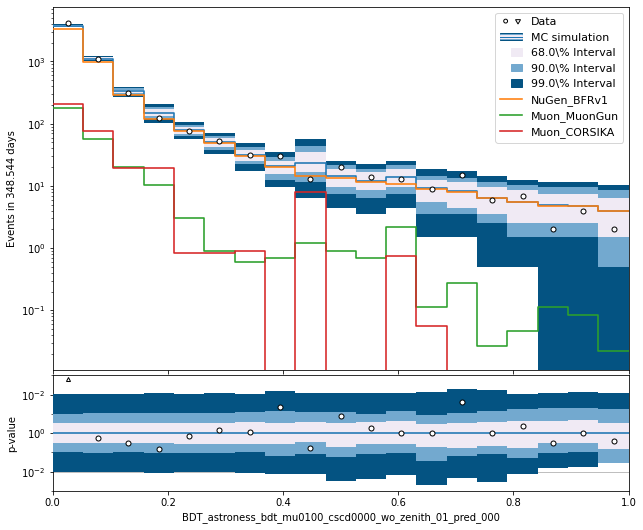

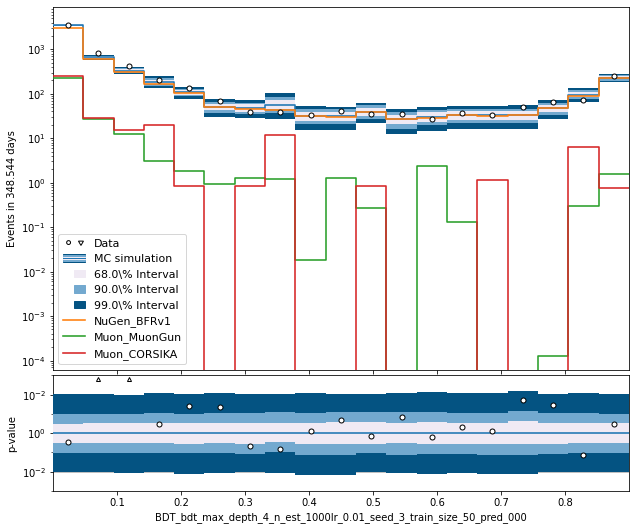

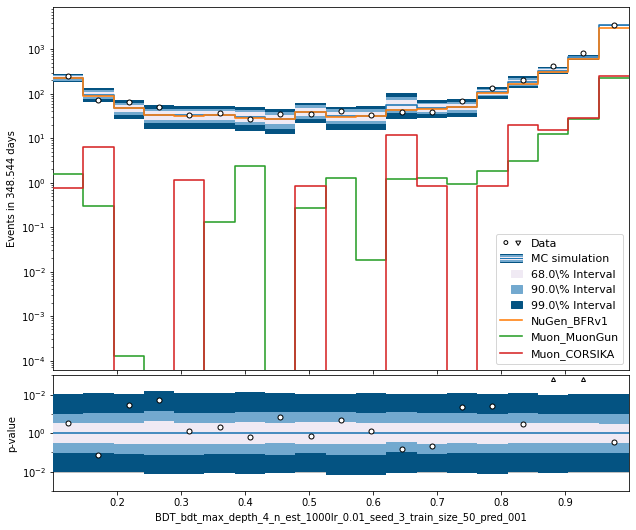

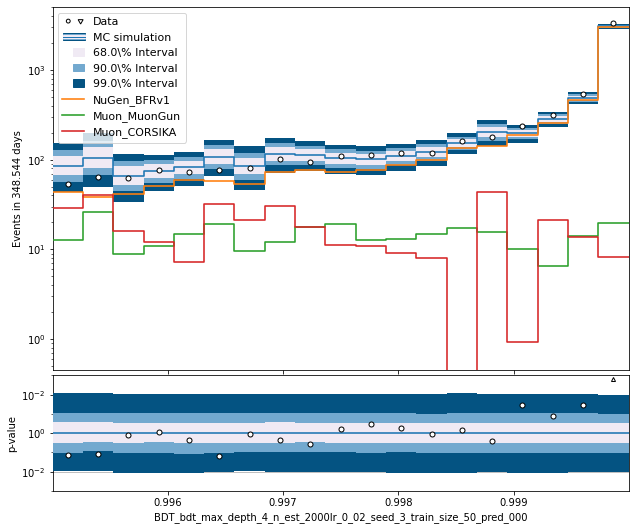

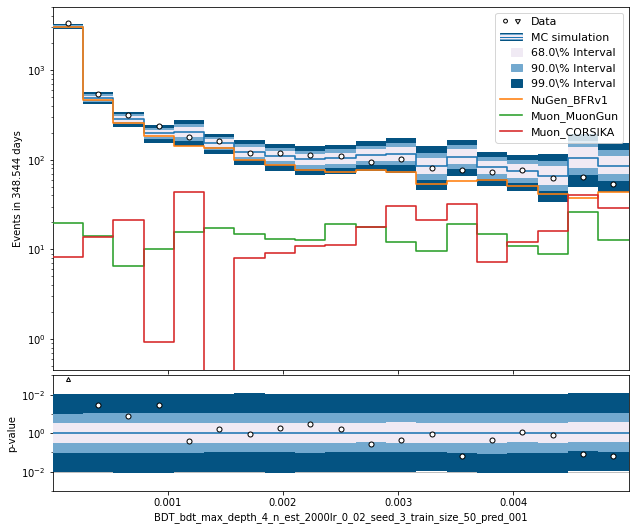

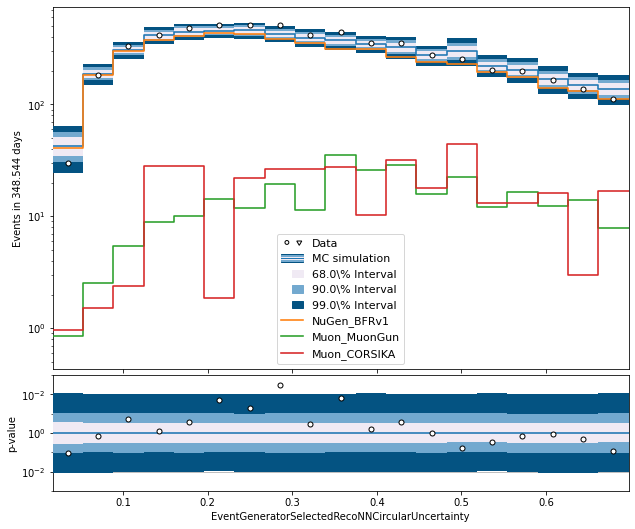

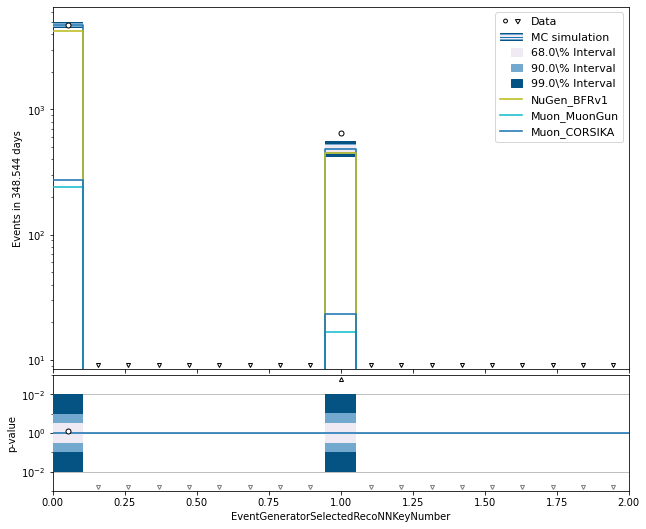

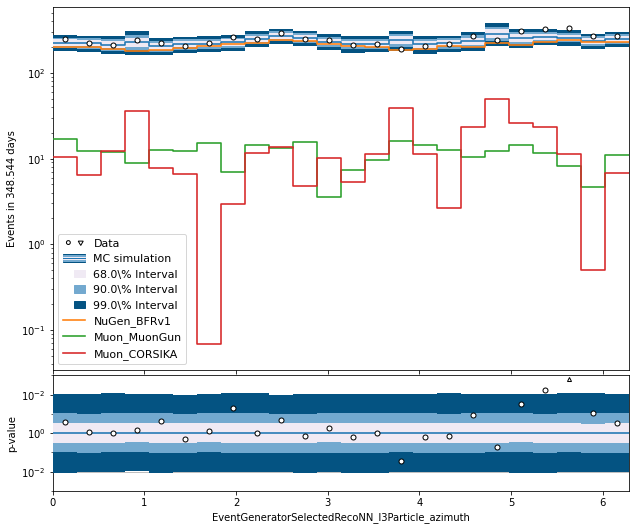

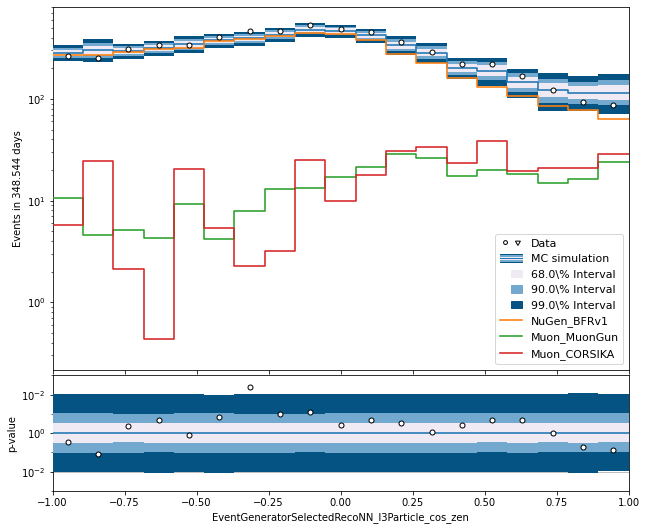

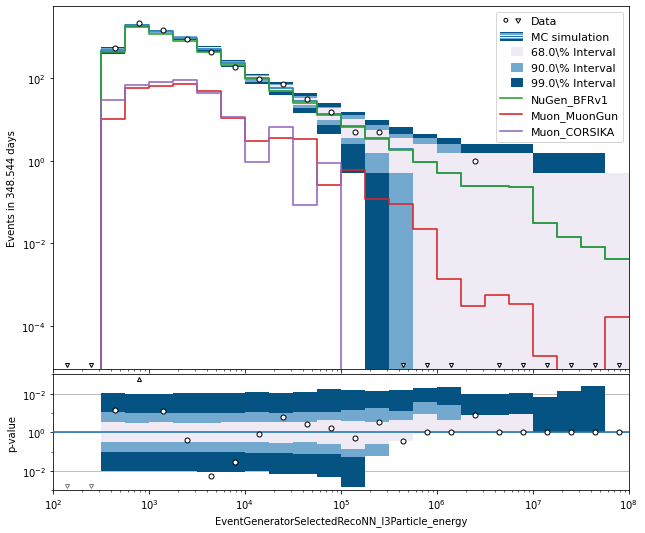

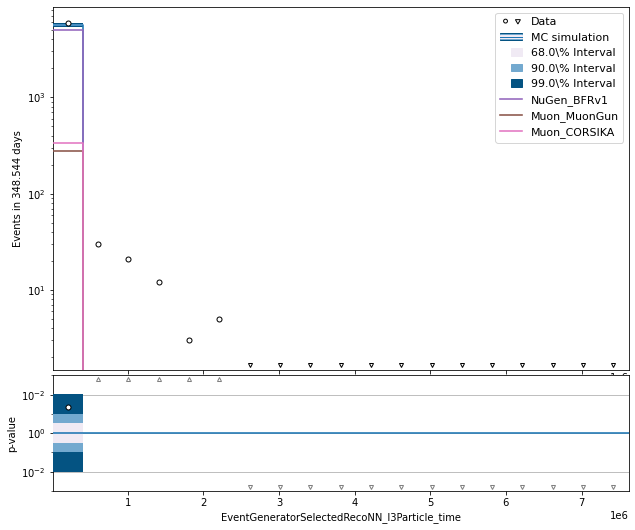

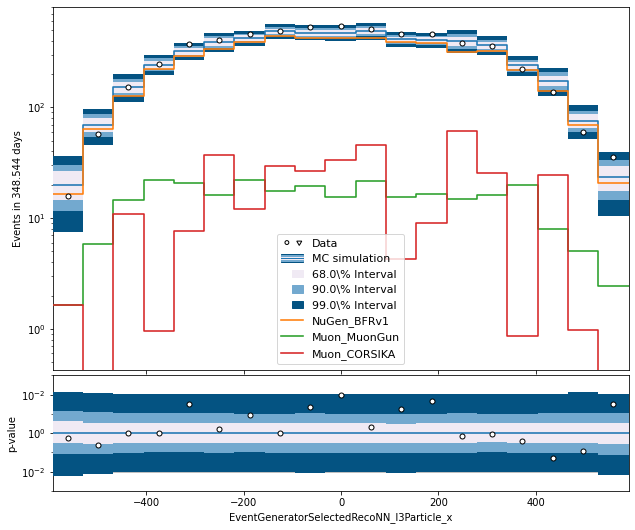

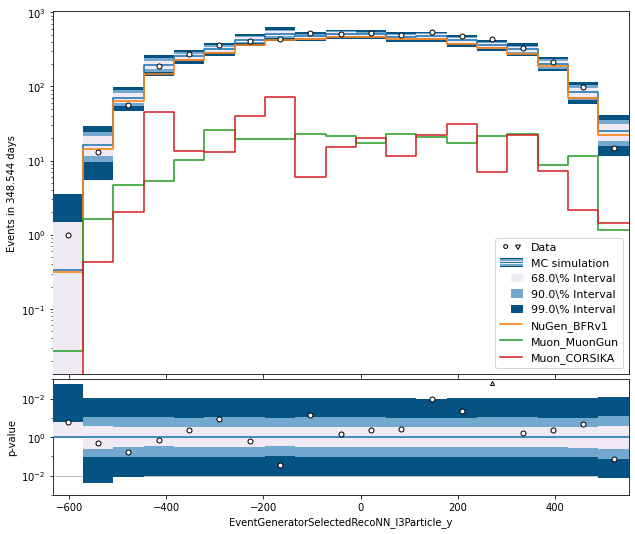

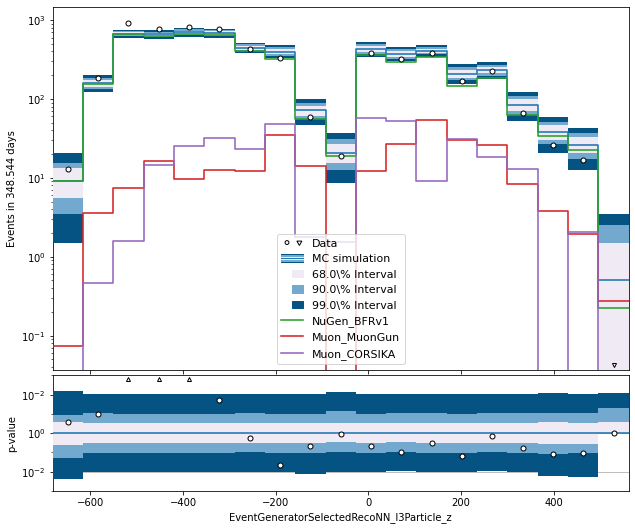

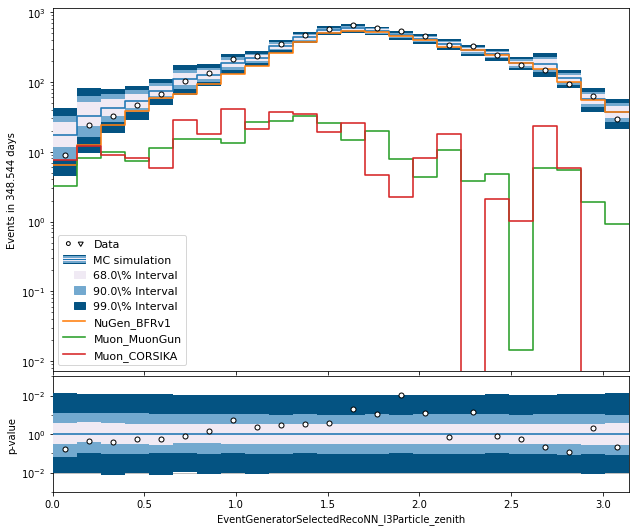

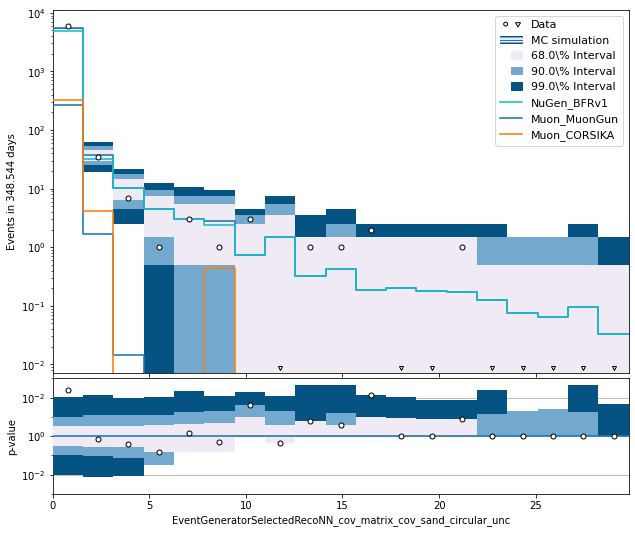

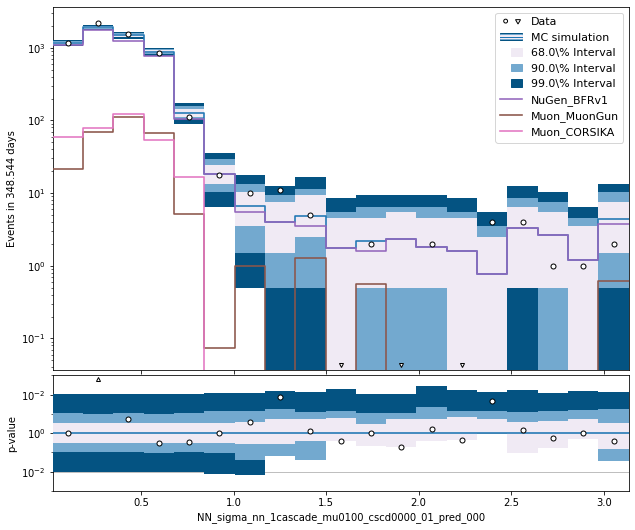

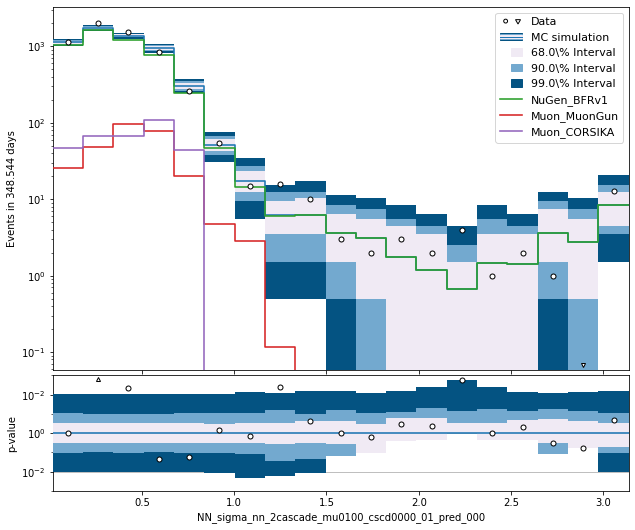

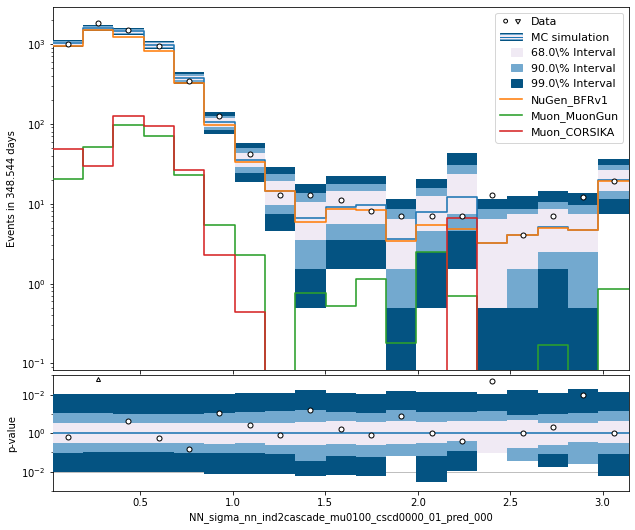

In [33]:
    
key_patterns = [
    'CVMultiplicity',
    'CVStatistics',
    'MPEFit_azimuth',
    'MPEFit_z',
    'MPEFit_c',
    'NN_',
    'BDT_',
    'EventGeneratorSelectedRecoNN',
    #---'event_selection_egen_seed',
    #'DNNCascadeSelectionRecoFeatures',
    #'DeepLearningReco_event_selection_veto_classifier_01__test_p_is_veto_event',
    #---'DeepLearningReco_event_selection_veto_classifier_vertex_early_01_p_is_veto_event',
    #---'DeepLearningReco_event_selection',
    #'event_selection_cascade_z',
    #'EventGeneratorSelectedReco_I3Particle',
    #---'event_selection_cascade_',
    #'EventGenerator_cascade_7param_noise_tw_BFRv1Spice321_01_I3Particle_',
    #'EventGenerator_cascade_7param_noise_tw_BFRv1Spice321_01__bfgs_gtol_10_I3Particle',
    #'BDT_final_starting_300m_01',
    #'BDT_bdt_max_depth_4_n_est_2000lr_0_02_seed_3_train_size_50',
    #'BDT_bdt_max_depth_4_n_est_1000lr_0.01_seed_3_train_size_50',
]
avoid_patterns = [
    'runtime',
    'NN_unc',
    'veto_classifier',
    'DeepLearningReco_event_selection_cascade_dir_01',
    'energy_fraction_2',
    'DNNCascadeSelectionRecoFeatures_log',
    'DeepLearningReco_event_selection_egen_seed_dir_01',
    'BDT_astroness_bdt_mu0100_cscd0000_wo_energy_01_pred_000',
    'BDT_astroness_bdt_mu0100_cscd0000_wo_energy_zenith_01_pred_000',
]

value_ranges = [
    #[-1., 1.],
    [-0.6, -0.3],
    [-0.3, 0.],
    [0., 0.3],
    [0.3, 0.6],
    #[-0.65, 0.6],
]
eff_ranges = [
    [0.9, 1.1],
    #[1., 1.1],
    #[0.9, 1.0],
]
abs_ranges = [
    #[0.9, 1.1],
    [1., 1.1],
    [0.9, 1.0],
]
scat_ranges = [
    [0.9, 1.1],
    #[1., 1.1],
    #[0.9, 1.0],
]
snowstorm_priors = {}
for value_range in value_ranges:
    for abs_range in abs_ranges:
        for scat_range in scat_ranges:
            for eff_range in eff_ranges:
                name = 'H0 [{:0.2f}, {:0.2}] | abs. [{:0.2f}, {:0.2}] | scat. [{:0.2f}, {:0.2}] | eff. [{:0.2f}, {:0.2}]'.format(
                    *(value_range + abs_range + scat_range + eff_range))
                snowstorm_priors[name] = {
                    'Absorption': abs_range,
                    'Scattering': scat_range,
                    'DOMEfficiency': eff_range,
                    'HoleIceForward_Unified_00': value_range,
                }
snowstorm_priors = None


def mask_func(df):
    mask = np.ones(len(df), dtype=bool)
    return mask

possible_keys = []
for key in dfs['exp'].keys():
    match_pattern = False
    for avoid_pattern in avoid_patterns:
        if avoid_pattern in key:
            match_pattern = True
            break
    if not match_pattern:
        possible_keys.append(key)

data_mc_plot_dir = '{}/data_mc'.format(plot_dir)
if not os.path.exists(data_mc_plot_dir):
    print('Creating directory:', data_mc_plot_dir)
    os.makedirs(data_mc_plot_dir)
    
for key in tqdm(sorted(set(possible_keys))):
    for key_pattern in key_patterns:
        if key_pattern in key:
            if key in df_mc:
                print(key)
                fig, ax_dict, result_tray = data_mc_plot(
                    key, df_mc=df_mc, df_exp=dfs['exp'],
                    mask_func=mask_func, add_parts=True,
                    snowstorm_priors=snowstorm_priors,
                )
                title = ''
                for prior_key, value_range in priors_dict.items():
                    title += '{}: [{:3.2f}, {:3.2f}] '.format(
                        prior_key, *value_range)
                ax_dict['PlotHistAggerwal'].set_title(title)
                fig.savefig('{}/data_mc/data_mc_{}.png'.format(
                    plot_dir, key))
                break
            